# Agenda
Spectral clustering of GPs' bitmaps.



In [1]:
# Installing Libraries (if not installed)
#!pip3 install jupyterlab-git
#!pip3 install matplotlib
#!pip3 install scikit-learn
#!pip3 install seaborn
#!pip3 install numpy
#!pip3 install pandas
#!pip3 install so4gp
#!pip3 install scipy
#!pip3 install sympy

# Import libraries <a name="lib-import"></a>

In [31]:
# Importing Libraries
import pandas as pd
import numpy as np
from numpy.linalg import svd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import sympy
import scipy


from scipy.sparse import csgraph, csr_matrix
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import kneighbors_graph
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import homogeneity_score, completeness_score,v_measure_score, confusion_matrix, accuracy_score
from numpy import linalg as la

In [21]:
import so4gp as sgp

## Data set
Retrieving data set and the features

In [22]:
ds = sgp.DataGP('data\DATASET.csv')

data_size = ds.row_count
features = np.array(ds.data, dtype=np.float64)
features

array([[30.,  3.,  1., 10.,  2.,  4.],
       [35.,  2.,  2.,  8.,  2.,  4.],
       [40.,  4.,  2.,  7.,  2.,  4.],
       [50.,  1.,  1.,  6.,  2.,  4.],
       [52.,  7.,  1.,  2.,  2.,  4.]])

In [23]:
bm_matrix = []
for i in ds.attr_cols:
    bm = sgp.gibitmap(ds, i)
    bm_matrix.append(bm)
    
bm_matrix = np.array(bm_matrix, dtype=int)

In [24]:
feature_X = features[:, [0,3]]
feature_X

array([[30., 10.],
       [35.,  8.],
       [40.,  7.],
       [50.,  6.],
       [52.,  2.]])

## Train similirity labels

### a. Retrieving training data set (X, y)

In [25]:
# X (2 features at a time)
X = np.zeros((data_size, data_size))
y  = np.zeros((data_size,))

for i in range(data_size):
    for j in range(data_size):
        if (feature_X[i][0] == feature_X[j][0]) or (feature_X[i][1] == feature_X[j][1]):
            pass
        elif (feature_X[i][0] > feature_X[j][0]) and (feature_X[i][1] > feature_X[j][1]):
            X[i][j] = 1
            X[j][i] = 1
            if y[i] == 0:
                y[i] = 1
            if y[j] == 0:
                y[j] = 1
        elif (feature_X[i][0] > feature_X[j][0]) and (feature_X[i][1] < feature_X[j][1]):
            X[i][j] = -1
            X[j][i] = -1
            if y[i] == 0:
                y[i] = -1
            if y[j] == 0:
                y[j] = -1
#for i in range(data_size):
#    u_count = np.unique(X[i], return_index=True, return_counts=True)
#    print(u_count)
#    i_max = u_count[2].argmax()
#    y[i] = u_count[0][i_max] 
X

array([[ 0., -1., -1., -1., -1.],
       [-1.,  0., -1., -1., -1.],
       [-1., -1.,  0., -1., -1.],
       [-1., -1., -1.,  0., -1.],
       [-1., -1., -1., -1.,  0.]])

In [26]:
#y  = np.array([2,2,2,2,2], dtype=int)
print(y)

[-1. -1. -1. -1. -1.]


### b. Constructing KNN Classifier

Using supervised learning

Adopted from [Analyticsvidhya](https://www.analyticsvidhya.com/blog/2021/01/a-quick-introduction-to-k-nearest-neighbor-knn-classification-using-python/)

In [32]:
# Splitting the dataset into the Training set (0.5 od data set) and Test set (0.5 of data set)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.50, random_state = 0)


In [33]:
# Feature Scaling (if you have large values otherwise skip)

#sc = StandardScaler()
#X_train = sc.fit_transform(X_train)
#X_test = sc.transform(X_test)

In [36]:
# Training the K-NN model on the Training set
classifier = KNeighborsClassifier(n_neighbors = 2, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)


KNeighborsClassifier(n_neighbors=2)

In [37]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)
y_pred

array([-1., -1., -1.])

In [39]:
# Making the Confusion Matrix
confusion_matrix(y_test, y_pred), accuracy_score(y_test, y_pred)

(array([[3]], dtype=int64), 1.0)

## Proposed Approach
1. We will have to decompose superset GPs into their individual 2x2 subsets and compute their supports through clustering. 

2. Then, we apply antimonotonicity principle to infer the support of the superset.

## a. KMeans Clustering
Produces labels that are not very accurate in partitioning data points.

[0 0 2 1 0]


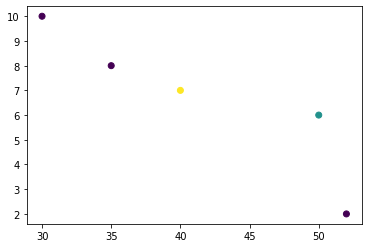

In [9]:
# Training
# Using KMeans clustering (NOT VERY  ACCURATE)
num_clusters = 3
kmean_labels = KMeans(n_clusters=num_clusters).fit_predict(X)
print(kmean_labels)

plt.scatter(feature_X[:,0], feature_X[:,1], c=kmean_labels)
#plt.scatter(feature_X[:,0], feature_X[:,1], c=y )

plt.show()

In [10]:
# Evaluation of clustering result of KMeans (true_labels, predicted_labels)
homogeneity_score(y, kmean_labels), completeness_score(y , kmean_labels), v_measure_score(y , kmean_labels)

(1.0, 0.0, 0.0)

## b. Spectral Clustering

Adopted from: [Towards data science](https://towardsdatascience.com/graph-laplacian-and-its-application-in-machine-learning-7d9aab021d16)

### 1. Deriving Graph Laplacian representation
L = D-W

D: Degree matrix

W: Similarity graph

In [11]:
# Degree Matrix

W = X
D = W.sum(axis=1)
D = np.diag(np.asarray(D).reshape(data_size,))
D

array([[-4.,  0.,  0.,  0.,  0.],
       [ 0., -4.,  0.,  0.,  0.],
       [ 0.,  0., -4.,  0.,  0.],
       [ 0.,  0.,  0., -4.,  0.],
       [ 0.,  0.,  0.,  0., -4.]])

In [12]:
# Laplacian Matrix
L = D - W
L

array([[-4.,  1.,  1.,  1.,  1.],
       [ 1., -4.,  1.,  1.,  1.],
       [ 1.,  1., -4.,  1.,  1.],
       [ 1.,  1.,  1., -4.,  1.],
       [ 1.,  1.,  1.,  1., -4.]])

In [13]:
# Laplacian Matrix

L = csgraph.laplacian(W, normed=False)
L#.toarray()

array([[-4.,  1.,  1.,  1.,  1.],
       [ 1., -4.,  1.,  1.,  1.],
       [ 1.,  1., -4.,  1.,  1.],
       [ 1.,  1.,  1., -4.,  1.],
       [ 1.,  1.,  1.,  1., -4.]])

In [14]:
# Normalized Laplacian Matirx: 

L_norm = csgraph.laplacian(W, normed=True)
L_norm#.toarray()

C:\Users\dowuor\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\sparse\csgraph\_laplacian.py:118: RuntimeWarning: invalid value encountered in sqrt
  w = np.where(isolated_node_mask, 1, np.sqrt(w))


array([[ 1., nan, nan, nan, nan],
       [nan,  1., nan, nan, nan],
       [nan, nan,  1., nan, nan],
       [nan, nan, nan,  1., nan],
       [nan, nan, nan, nan,  1.]])

### 2. Computing eigenvalues

In [15]:
# Finding eigen values and eigen vectors
e, evecs = la.eig(L)#.todense())
e, evecs

(array([-5.,  0., -5., -5., -5.]),
 array([[-0.89442719,  0.4472136 ,  0.        ,  0.        ,  0.        ],
        [ 0.2236068 ,  0.4472136 ,  0.70710678,  0.24828177,  0.46829291],
        [ 0.2236068 ,  0.4472136 , -0.47140452,  0.49656353,  0.18731716],
        [ 0.2236068 ,  0.4472136 ,  0.23570226,  0.08276059, -0.84292723],
        [ 0.2236068 ,  0.4472136 , -0.47140452, -0.82760589,  0.18731716]]))

In [16]:
# No. of eigen values equal to 0
e_rounded_off = e.round(5)
e_rounded_off[e_rounded_off == 0].shape
e_rounded_off

array([-5.,  0., -5., -5., -5.])

### 3. Partitioning data points

In [17]:
sorted_idxs = np.argsort(e_rounded_off)
print(sorted_idxs)
sorted_idxs[-2:]

[0 2 3 4 1]


array([4, 1], dtype=int64)

[1 2 1 0 1]


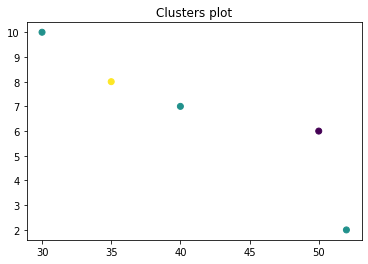

In [18]:
num_clusters = 3
evecs_last_2 = evecs[0:, sorted_idxs[-2:]]
new_labels = KMeans(n_clusters=num_clusters).fit_predict(evecs_last_2)
print(new_labels)

# Plot cluster result
plt.scatter(feature_X[:,0], feature_X[:,1], c=new_labels.astype(float))
plt.title("Clusters plot")
plt.show()

In [19]:
# Evaluation of clustering result of KMeans (true_labels, predicted_labels)
homogeneity_score(y , new_labels), completeness_score(y , new_labels), v_measure_score(y , new_labels)

(1.0, 0.0, 0.0)